# Определение стоимости автомобилей

**Описание исследования.** Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. В проекте будем строить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель исследования.**

Целью данного исследования является подбор быстрой модели (которая тратит меньше ресурсов по сравнению с другими) для предсказания цены автомобиля на основании имеющихся данных.

**Этапы исследования.**

1. Подготовка данных к работе модели.
2. Разработка 3 моделей для решения задачи регрессии:
    - линейная регрессия
    - LightGBM
    - CatBoost
3. Оценка времени обучения, времени предсказания и метрики RMSE для каждой модели. Сравнение результатов.
4. Выбор лучшей модели и оценка ее работы на тестовой выборке.

## Подготовка данных

In [1]:
!pip install scikit-learn==1.6.1  -q

In [2]:
!pip install phik -q

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import phik
import sklearn
import math
import lightgbm as lgb
import catboost
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import root_mean_squared_error, make_scorer, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder)

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from time import time


from phik import phik_matrix

In [4]:
RANDOM_STATE = 42
TEST_SIZE =0.25

In [5]:
try:
    autos = pd.read_csv('/datasets/autos.csv')  
except:
    autos = pd.read_csv(r"C:\Users\user1\Documents\Учеба Data science\Проекты спринтов\Численные методы\autos.csv")
    

Посмотрим `info` и `describe`, `shape`

In [6]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Описание describe:
1. Видим что в данных есть выбросы и аномалии.
    - минимальная цена - 0. Максимум 20000.
    - год регистрации - от 1000 до 9999. 
    - минимальная мощность - 0 лс.
2. Количественные данные нужно обрабатывать.

In [8]:
autos.shape

(354369, 16)

Приведем названия колонок к стандарту

In [9]:
autos.columns = autos.columns.str.lower()

In [10]:
autos.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'lastseen']

In [11]:
def isna(df):
    number_isna = df.isna().sum()
    number_duplicated = df.duplicated().sum()
    if (number_isna.sum() > 0) or (number_duplicated > 0):
        print ('Количество пропусков составляет:')
        display (number_isna)
        print (f'Количество явных полных дубликатов составляет {number_duplicated}')
    else:
        print ('Пропусков и явных дубликатов не обнаружено')

In [12]:
isna (autos)

Количество пропусков составляет:


date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
lastseen                  0
dtype: int64

Количество явных полных дубликатов составляет 4


In [13]:
autos[autos.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,lastseen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Удалим дубликаты.

In [14]:
autos = autos.drop_duplicates().reset_index(drop=True)

In [15]:
autos.shape

(354365, 16)

In [16]:
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'lastseen'],
      dtype='object')

Теперь перейдем к пропускам. Рассмотрим их в процентном отношении.

Для упрощения исследования оставим в таблице только те столбцы, которые, по логике оказывают влияние на целевой признак `price`.

In [17]:
autos = autos[['price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type',
       'brand', 'repaired']]

In [18]:
auto_isna = pd.DataFrame(autos.isna().sum())
auto_isna.columns = ['count']
auto_isna['share'] = autos.isna().mean()
auto_isna

,count,share
price,0,0.000000
vehicle_type,37490,0.105795
registration_year,0,0.000000
gearbox,19833,0.055968
power,0,0.000000
model,19705,0.055607
kilometer,0,0.000000
fuel_type,32895,0.092828
brand,0,0.000000
repaired,71154,0.200793


In [19]:
autos['vehicle_type'].value_counts(dropna=False)

sedan          91457
small          79830
wagon          65165
NaN            37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Есть пропуски в размере 10,6 процентов в столбце тип кузова. Определим эту группу как отдельную категорию "неизвестный тип" - unknown.

In [20]:
autos['vehicle_type'].fillna('unknown', inplace=True)

Аналогично поступим с пропусками в столбцах `gearbox`,`model`,`fuel_type` - ставим заглушки.

In [21]:
list = ['gearbox','model','fuel_type']
for i in list:
    autos[i].fillna('unknown', inplace=True)

Для столбца с ремонтом пропуски примем как значение, что ремонта не было.

In [22]:
autos['repaired'].fillna('no', inplace=True)

Далее построим графики для целевого признака.

In [23]:
def hist(df,col):
    plt.figure(figsize=(20,10))

    plt.subplot(1,2,1)
    sns.histplot(data=df, x=col, bins = 50)
    plt.ylabel('Количество значений',fontsize=20)
    plt.xlabel(f'{col}',fontsize=20)
    plt.title('Гистограмма',fontsize=20)

    plt.subplot(1,2,2)
    sns.boxplot(data=df, x=col)
    plt.xlabel(f'{col}',fontsize=20)
    plt.title('Боксплот',fontsize=20)

    plt.suptitle(f'Гистограмма и боксплот для {col}',fontsize=30)

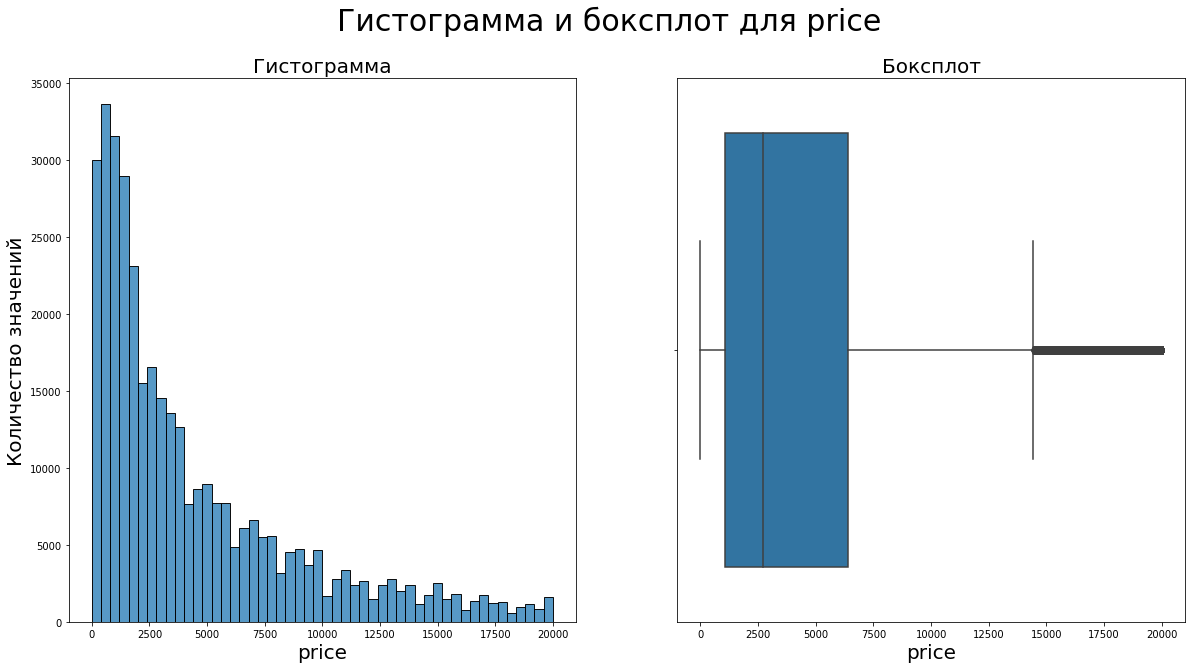

In [24]:
hist(autos, 'price')

 - Максимальное значение 20 000. 
 - Есть выбросы. Скорее всего обусловлены дорогим сегментом. Оставим эти значения.
 - Видим, что есть нулевая цена. Рассмотрим подробнее.

In [25]:
autos[autos['price'] == 0].count()

price                10772
vehicle_type         10772
registration_year    10772
gearbox              10772
power                10772
model                10772
kilometer            10772
fuel_type            10772
brand                10772
repaired             10772
dtype: int64

Количество объявлений с нулевой ценой - 10772. Не будем учитывать их в нашей работе. Также имеются объявления с ценой меньше 1000 евро - аналогично их учитывать не будем.

In [26]:
autos = autos[autos['price'] > 1000]

In [27]:
autos.shape

(266391, 10)

Далее изучим год регистрации.

In [28]:
autos['registration_year'].describe()

count    266391.000000
mean       2004.785623
std          56.597238
min        1000.000000
25%        2001.000000
50%        2005.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [29]:
autos['registration_year'].quantile(0.05)

1994.0

In [30]:
autos['registration_year'].quantile(0.99)

2018.0

Оставим данные с 1994 по 2016 год.

In [31]:
autos = autos.query('registration_year >= 1994 and registration_year <= 2016')

In [32]:
autos.shape

(242938, 10)

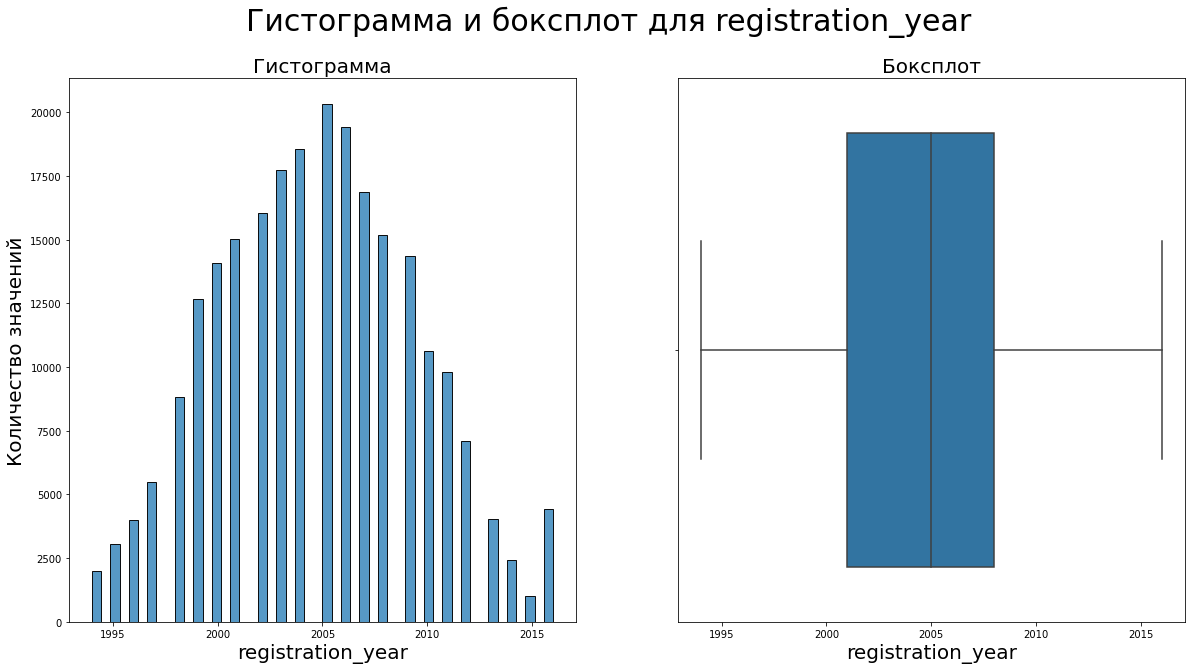

In [33]:
hist(autos,'registration_year')

In [34]:
autos['power'].describe()

count    242938.000000
mean        123.876874
std         185.915252
min           0.000000
25%          80.000000
50%         116.000000
75%         150.000000
max       20000.000000
Name: power, dtype: float64

In [35]:
autos['power'].quantile(0.05)

0.0

In [36]:
autos['power'].quantile(0.99)

306.0

In [37]:
autos[autos['power'] == 0].count()

price                15988
vehicle_type         15988
registration_year    15988
gearbox              15988
power                15988
model                15988
kilometer            15988
fuel_type            15988
brand                15988
repaired             15988
dtype: int64

Имеется 33189 объявлений с мощностью автомобиля - 0. Не будем их учитывать.

In [38]:
autos = autos[autos['power'] != 0]

Возьмем данные после 5 квантиля.

In [39]:
autos = autos[autos['power'] >= 45]

Ограничим мощность - 600 лс.

In [40]:
autos = autos[autos['power'] <= 600]

In [41]:
autos.shape

(225904, 10)

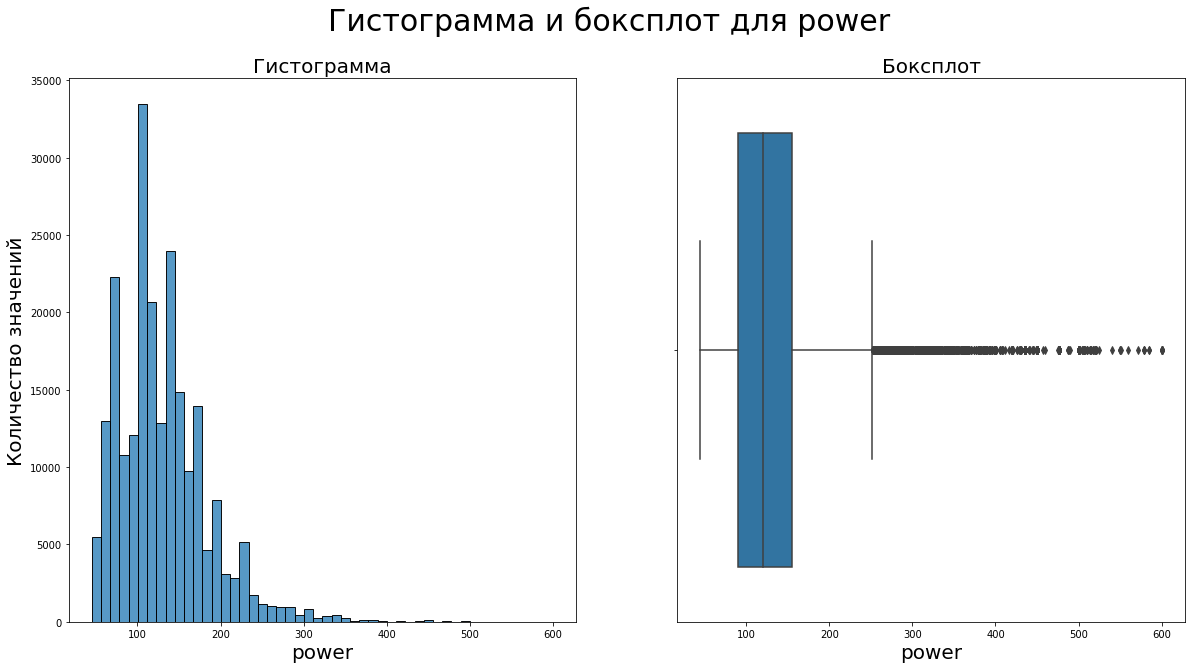

In [42]:
hist(autos,'power')

In [43]:
interval_cols = ['price', 'power']

Text(0.5, 1.0, 'Тепловой график корреляции признаков')

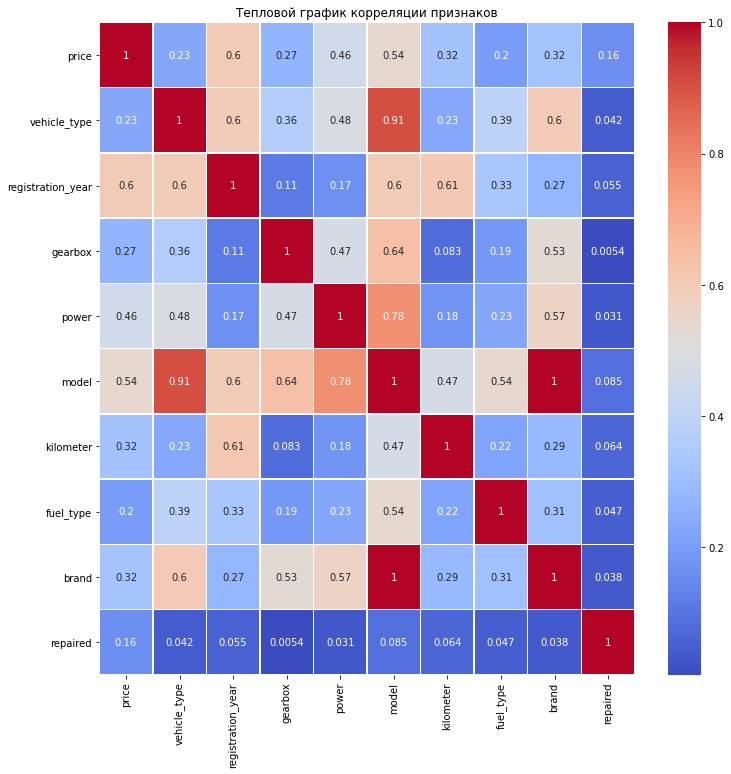

In [44]:
corr_matrix = autos.phik_matrix(interval_cols = interval_cols)
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title(f'Тепловой график корреляции признаков')

Видим мультиколлинераность - удалим признаки `vehicle_type` `brand`

In [45]:
autos = autos.drop(['vehicle_type', 'brand'], axis = 1)

**Вывод по предобработке и исследовательскому анализу:**
- Оставили только признаки, которые влияют на целевой.

- Удалены дубликаты и обработаны пропуски, заменены на unknown. В столбце 'repaired' пропуски отнесены к категории "no".

- Отфильтрован датафрейм. 
    - В целевом признаке 'price' не берем нулевые значения.
    - в registration_year взяли года с 1993 по 2019
    - по мощности берем для модели записи со значениями от 45 лс до 600 лс.

- построены графики
- построена тепловая карта корреляции признаков.

## Обучение моделей

Построим модели. Для подбора гиперпараметров будем использовать RandomizedSearchCV()

In [46]:
autos  = autos.drop_duplicates()

In [47]:
X = autos.drop('price', axis=1)
y = autos['price']

In [48]:
num_col = X.select_dtypes(include='number').columns.tolist()
cat_col = X.select_dtypes(exclude='number').columns.tolist()

In [49]:
print(num_col)
print(cat_col)

['registration_year', 'power', 'kilometer']
['gearbox', 'model', 'fuel_type', 'repaired']


In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

In [51]:
print(X_train.shape[0])
print(X_test.shape[0])

139041
46348


In [52]:
ohe_columns = ['model', 'gearbox', 'repaired','fuel_type']
num_columns = num_col

In [53]:
ohe_pipe = Pipeline(
    [(
        'simpleImputer_ohe',
        SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent'
        )
    ),
     (
         'ohe',
         OneHotEncoder(
             drop='first',
             handle_unknown='ignore',
             sparse_output=False
         )
     )
    ]
)

In [54]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [55]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()
    )
])

## Анализ моделей

Линейная регрессия.

In [56]:
param_grid = [
    {
        'models': [LinearRegression()],  
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [57]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    n_iter=5,
    scoring = 'neg_root_mean_squared_error',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

In [58]:
models = []
model_time_learn = []

In [59]:
start_learn = time()

randomized_search.fit(X_train, y_train)

end_learn = time()
time_learn = (end_learn - start_learn) / 60
model_time_learn.append(time_learn)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown

In [60]:
randomized_search.best_score_

-2428.0581695146975

In [61]:
models.append(randomized_search)

Перейдем к Градиентному бустингу.

LightGBM

In [62]:
X_train[cat_col] = X_train[cat_col].astype('category')
X_test[cat_col] = X_test[cat_col].astype('category')

In [63]:
lgbm_model = LGBMRegressor(objective='root_mean_squared_error',
                           random_state=RANDOM_STATE,
                           verbose=-1)

In [64]:
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5, 1],  
    'max_depth': [1, 2, 6]
}


random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model, 
    param_distributions=param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_iter=5
)


start_learn = time()

random_search_lgbm.fit(X_train, y_train)

end_learn = time()
time_learn = (end_learn - start_learn) / 60
model_time_learn.append(time_learn)

In [65]:
models.append(random_search_lgbm)

Построили вторую модель.

Теперь составим модель CatBoost

In [66]:
catboost_model = CatBoostRegressor(verbose=100,
                                   cat_features=cat_col,
                                   random_state=RANDOM_STATE)

In [67]:
param_grid = {
    'depth': [1, 5],
    'learning_rate': [0.1, 0.3]
}

random_search_catboost = RandomizedSearchCV(
    estimator=catboost_model, 
    param_distributions=param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_iter=1
)

start_learn = time()

random_search_catboost.fit(X_train, y_train)

end_learn = time()
time_learn = (end_learn - start_learn) / 60
model_time_learn.append(time_learn)

0:	learn: 4257.2889152	total: 72.3ms	remaining: 1m 12s
100:	learn: 2338.4123053	total: 1.56s	remaining: 13.9s
200:	learn: 2309.4804005	total: 3.02s	remaining: 12s
300:	learn: 2299.6894125	total: 4.47s	remaining: 10.4s
400:	learn: 2292.5584495	total: 5.93s	remaining: 8.86s
500:	learn: 2287.5749220	total: 7.34s	remaining: 7.32s
600:	learn: 2283.6807057	total: 8.8s	remaining: 5.84s
700:	learn: 2280.5853479	total: 10.2s	remaining: 4.36s
800:	learn: 2277.9929094	total: 11.7s	remaining: 2.9s
900:	learn: 2275.9681992	total: 13.1s	remaining: 1.44s
999:	learn: 2274.0667214	total: 14.7s	remaining: 0us
0:	learn: 4242.6570141	total: 18.3ms	remaining: 18.3s
100:	learn: 2344.1090868	total: 1.47s	remaining: 13.1s
200:	learn: 2314.7698079	total: 2.9s	remaining: 11.5s
300:	learn: 2303.2303569	total: 4.34s	remaining: 10.1s
400:	learn: 2296.3790718	total: 5.78s	remaining: 8.63s
500:	learn: 2291.3275159	total: 7.22s	remaining: 7.19s
600:	learn: 2287.7536043	total: 8.71s	remaining: 5.78s
700:	learn: 2284.6

In [68]:
models.append(random_search_catboost)

In [69]:
RMSE = []
model_time_predict = []

In [70]:
for i in models:
    RMSE.append(-i.best_score_)
    start_predict = time()
    i.predict(X_train)
    end_predict = time()
    time_predict = (end_predict - start_predict) / 60
    model_time_predict.append(time_predict) 

In [71]:
models_result = pd.DataFrame(
    {'model':['LinearRegression', 'LightGBM', 'CatBoost'],
     'RMSE': RMSE,
     'model_time_learn': model_time_learn,
     'model_time_predict': model_time_predict,
     
    }
)
models_result

,model,RMSE,model_time_learn,model_time_predict
0,LinearRegression,2428.058170,2.526569,0.013026
1,LightGBM,1710.893679,1.184046,0.021848
2,CatBoost,2267.286734,1.649016,0.003816


**Вывод:**
- обучили три модели: 
    - линейная регрессия
    - LightGBM
    - CatBoost
- Лучшей по критериям для заказчика является модель LightGBM. У нее лучшие показатели по времени и метрика RMSE находится в пределах границы 2500.

Оценим модель на тестовой выборке.

In [72]:
model_lgbm = random_search_lgbm.best_estimator_

In [74]:
start_test = time() 
RMSE_test = root_mean_squared_error(y_test, model_lgbm.predict(X_test))
end_test = time()
model_time_test = (end_test - start_test) / 60 
print('RMSE на тестовой выборке: ', RMSE_test)
print('Время предсказания на тестовой выборке: ', model_time_test)

RMSE на тестовой выборке:  1713.537967552705
Время предсказания на тестовой выборке:  0.0068559368451436365


**Вывод по работе модели на тестовой выборке:**

- RMSE - 1713.54
- Время предсказания - 0.0069
- Значения соответствуют условию.